In [94]:
from preprocessing import (grayzation, 
                           binarization,
                           pdf_file_to_array,
                           bytes_file_to_array,
                           visualize_images)
from detection import (get_nodes,
                       get_cells,
                       get_lines_Hough,
                       get_cells_maskrcnn, 
                       get_tables_maskrcnn,
                       visualize_table_images, 
                       visualize_cells)
from builder import (visualize_headers_and_records_cells,
                     split_into_headers_and_records_maskrcnn,
                     split_into_headers_and_records,
                     create_cell_dict,
                     build_structure,
                     fill_structure,
                     split_records,
                     visualize_cells_relationship)
from export import make_serialized_structure, save
from recognition import osr_detection
import os
import cv2
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [115]:
import time

def extract(file):
    low_dpi = 50
    high_dpi = 500
    # high_quality_images_array = bytes_file_to_array(file, high_dpi)
    # low_quality_images_array = bytes_file_to_array(file, low_dpi)

    # start_time = time.time()
    # high_quality_images_array = pdf_file_to_array(file, high_dpi)
    # elapsed_time = time.time() - start_time
    # print(f"high_quality_images_array {elapsed_time} seconds")

    # start_time = time.time()
    # low_quality_images_array = pdf_file_to_array(file, low_dpi)
    # elapsed_time = time.time() - start_time
    # print(f"low_quality_images_array {elapsed_time} seconds")

    input_folder = os.path.join(os.getcwd(), "input", "cache")
    high_quality_images_array = [cv2.imread(os.path.join(input_folder, "000124.jpg"))]
    low_quality_images_array = [cv2.imread(os.path.join(input_folder, "000124.jpg"))]

    start_time = time.time()
    high_quality_gray_images_array = grayzation(high_quality_images_array)
    elapsed_time = time.time() - start_time
    print(f"high_quality_gray_images_array {elapsed_time} seconds")

    visualize_images(high_quality_images_array)
    
    start_time = time.time()
    low_quality__gray_images_array = grayzation(low_quality_images_array)
    elapsed_time = time.time() - start_time
    print(f"low_quality__gray_images_array {elapsed_time} seconds")

    start_time = time.time()
    thresholded_images_array = binarization(high_quality_gray_images_array)
    elapsed_time = time.time() - start_time
    print(f"thresholded_images_array {elapsed_time} seconds")

    start_time = time.time()
    tables, _ = get_tables_maskrcnn(low_quality_images_array,
                                    low_dpi,
                                    high_quality_images_array,
                                    high_dpi)
    elapsed_time = time.time() - start_time
    print(f"tables {elapsed_time} seconds")

    visualize_table_images(tables)

    start_time = time.time()
    tables_cells = get_cells_maskrcnn(tables)
    elapsed_time = time.time() - start_time
    print(f"tables_cells {elapsed_time} seconds")

    visualize_cells(tables, tables_cells)

    # start_time = time.time()
    # table_cell_text = osr_detection(tables, tables_cells)
    # elapsed_time = time.time() - start_time
    # print(f"table_cell_text {elapsed_time} seconds")
    
    # start_time = time.time()
    # structure = make_serialized_structure(tables, tables_cells, table_cell_text)
    # elapsed_time = time.time() - start_time
    # print(f"results {elapsed_time} seconds")

    # start_time = time.time()
    # save(structure, 'yaml', file)
    # elapsed_time = time.time() - start_time
    # print(f"save {elapsed_time} seconds")

    # high_quality_images_array = pdf_file_to_array(file, high_dpi)
    # low_quality_images_array = pdf_file_to_array(file, low_dpi)
    # visualize_images(high_quality_images_array)

    # high_quality_gray_images_array = grayzation(high_quality_images_array)
    # low_quality__gray_images_array = grayzation(low_quality_images_array)
    # thresholded_images_array = binarization(high_quality_gray_images_array)
    # tables, _ = get_tables_maskrcnn(low_quality_images_array,
    #                              low_dpi,
    #                              high_quality_images_array,
    #                              high_dpi)
    # visualize_table_images(tables)

    # tables_cells = get_cells_maskrcnn(tables)
    # visualize_cells(tables, tables_cells)

    tables = grayzation(tables)
    tables_lines = get_lines_Hough(tables)
    tables_nodes = get_nodes(tables, tables_lines)
    tables_cells = get_cells(tables, tables_nodes)
    visualize_cells(tables, tables_cells)

    # split_into_headers_and_records_maskrcnn(tables[0], tables_cells[0])
    # table_cell_text = osr_detection(tables, tables_cells)
    
    # start_time = time.time()
    # table_cell_text = osr_detection(tables, tables_cells)
    # elapsed_time = time.time() - start_time
    # print(f"table_cell_text {elapsed_time} seconds")

    # results = make_serialized_structure(tables, tables_cells, table_cell_text)
    # save(results, 'yaml', file)

    return tables, tables_cells #, table_cell_text

high_quality_gray_images_array 0.0 seconds


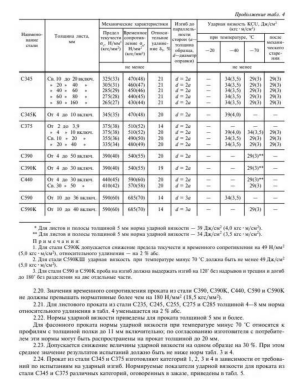

low_quality__gray_images_array 0.0010025501251220703 seconds
thresholded_images_array 0.0 seconds
tables 4.989158630371094 seconds


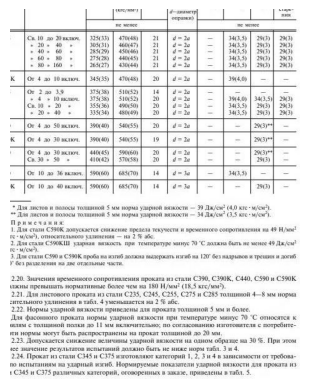

tables_cells 5.690792083740234 seconds


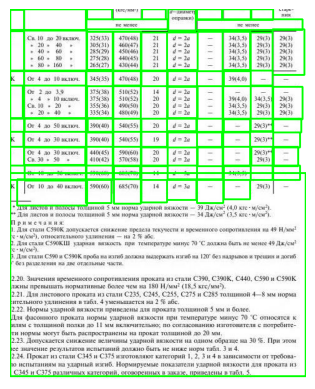

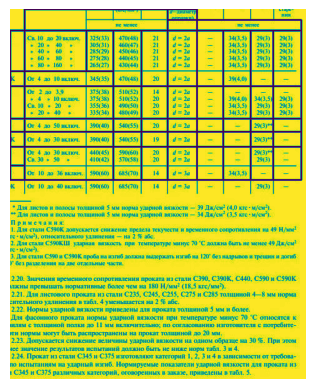

In [116]:
input_folder = os.getcwd() + "\input"
pdf_files = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith(".pdf")]
file = pdf_files[0]
tables, tables_cells = extract(file)

In [4]:
header_cells, record_cells, records_list = split_into_headers_and_records(tables_cells[0])

cell_counts {41: 2, 62: 2, 153: 3, 229: 2, 329: 3, 593: 2, 711: 10, 922: 10, 1208: 10, 1490: 10, 1697: 10}
sorted_cell_counts [(1697, 10), (1490, 10), (1208, 10), (922, 10), (711, 10), (593, 2), (329, 3), (229, 2), (153, 3), (62, 2), (41, 2)]
change_y 593
records_list [[(2581, 711, 2880, 938), (2288, 717, 2572, 934), (3140, 719, 3385, 934), (11, 721, 362, 934), (1663, 721, 1952, 931), (366, 722, 1052, 933), (1046, 722, 1351, 932), (1953, 722, 2285, 933), (2881, 722, 3132, 936), (1350, 725, 1667, 931)], [(351, 922, 1051, 1216), (10, 927, 364, 1217), (2282, 927, 2573, 1219), (2578, 929, 2876, 1223), (2884, 933, 3132, 1220), (1952, 934, 2284, 1217), (3145, 934, 3388, 1216), (1344, 935, 1661, 1208), (1669, 935, 1950, 1216), (1057, 937, 1346, 1211)], [(15, 1208, 360, 1496), (347, 1209, 1057, 1492), (2576, 1209, 2876, 1503), (3144, 1215, 3390, 1496), (1050, 1216, 1348, 1488), (2883, 1216, 3134, 1499), (1956, 1217, 2282, 1496), (2285, 1217, 2579, 1492), (1671, 1218, 1951, 1496), (1345, 1219, 

In [ ]:
header_cell_dict = create_cell_dict(header_cells)
print(header_cell_dict)
for main_cell, overlapping_cells in header_cell_dict.items():
    visualize_cells_relationship(tables[0], main_cell, overlapping_cells)

In [19]:
structure = []

rectangle_text_dict = table_cell_text[0]

for cell in header_cells:
    structure.append(build_structure(cell,
                                     rectangle_text_dict, 
                                     header_cell_dict))
    
print(rectangle_text_dict)
print(header_cell_dict)
print(structure)

{(1, 41, 365, 724): 'Наимсно- ванис стали ', (1, 1697, 358, 1914): 'C285 ', (10, 927, 364, 1217): 'C245 ', (11, 721, 362, 934): 'С235 ', (15, 1208, 360, 1496): 'C255 ', (19, 1491, 360, 1706): 'C275 ', (347, 1209, 1057, 1492): 'От 4 до 10 включ: Св: 10 20 20 40 ', (350, 1700, 1056, 1912): 'От 4 до 10 включ: Св: 10 20 ', (351, 922, 1051, 1216): 'От 4 до 20 включ Св: 20 25 25 30 ', (355, 1496, 1054, 1702): 'От 4 до 10 включ: Св: 10 20 ', (359, 62, 1068, 712): 'Толщина полки, ям ', (366, 722, 1052, 933): 'От 4 до 20 включ. Св: 20 40 ', (1046, 722, 1351, 932): '235(24) 225(23) ', (1047, 1494, 1350, 1702): '275(28) 275(28) ', (1050, 1216, 1348, 1488): '255(26) 245(25) 235(24) ', (1051, 153, 1351, 588): 'Предел текучести Н/мм? кгс /мм? 6x ', (1051, 1703, 1348, 1907): '285(29) 275(28) ', (1054, 597, 1952, 717): 'нс менсс ', (1057, 937, 1346, 1211): '245(25) 235(24) 235(24) ', (1344, 935, 1661, 1208): '370(38) 370(38) 370(38) ', (1345, 1219, 1662, 1487): '380(39) 370(38) 370(38) ', (1349, 1495,

### TATR

In [1]:
from transformer.core import TableRecognizer
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import cv2
import os

m = TableRecognizer(
    checkpoint_path= os.path.join(os.getcwd(), 'transformer', 'TATR-v1.1-All-msft.pth'),
    mode='detection'
)

input_folder = os.path.join(os.getcwd(), "input", "cache") 
# input_folder = os.path.join(os.getcwd(), "input") 

image = Image.open(os.path.join(input_folder, "000034.jpg")).convert("RGB")

results = m.predict(image_path=image)
output_image = results["debug_image"]

plt.imshow(output_image)
plt.axis('off')
plt.show()

tables_cells = []

for idx, score in enumerate(results["scores"].tolist()):
    if score < 0.93:
        continue
    
    xmin, ymin, xmax, ymax = list(map(int, results["boxes"][idx]))
    tables_cells.append([xmin, ymin, xmax, ymax])

# tables_cells = results['boxes'].to(torch.int).tolist()

print("results", tables_cells)

TypeError: TableRecognizer.__init__() got an unexpected keyword argument 'mode'

In [ ]:
# results["scores"].tolist()
# for label in results["labels"].tolist():
#     print(f"{model.config.id2label[label]}")
results["labels"].tolist()

NameError: name 'model' is not defined

In [82]:
tables_cells[:1]

[[98, 12, 282, 590]]

In [96]:
from typing import List, Tuple

def visualize_cells_local(tables: List[np.ndarray],
                         tables_cells: List[List[Tuple[int, int, int, int]]]) -> None:
    for image, cells in zip(tables, tables_cells):
        # copy_image = image.copy()
        for cell in cells:
            copy_image = image.copy()
            x1, y1, x2, y2 = cell
            # xc, yc, w, h = cell
            print(x1, y1, x2, y2)
            # Draw cell on the image
            cv2.rectangle(copy_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # cv2.rectangle(copy_image, (xc - h/2, yc - w/2), (xc + h/2, yc - w/2), (0, 255, 0), 2)

            # Display the image with cells
            plt.imshow(copy_image)
            plt.axis('off')
            plt.show()

108 5 286 191


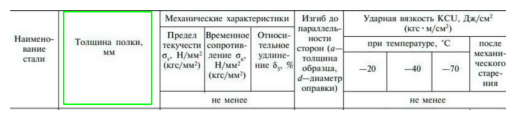

699 167 1000 192


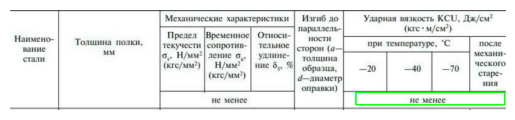

278 18 387 179


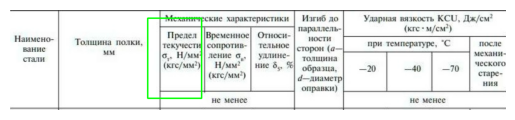

861 5 922 192


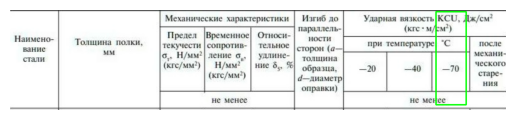

101 9 284 177


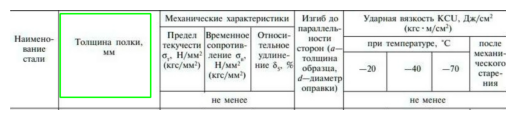

577 6 684 191


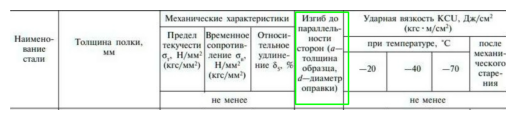

687 5 771 192


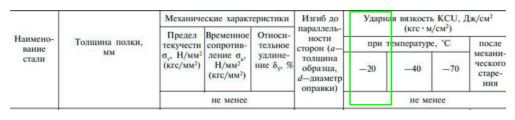

766 5 861 192


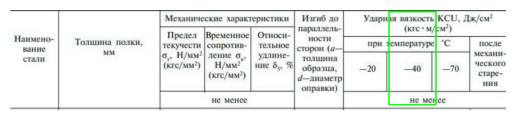

6 47 1000 80


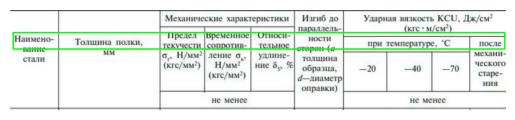

381 34 489 183


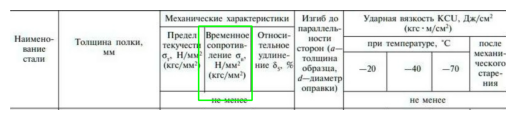

922 5 1001 192


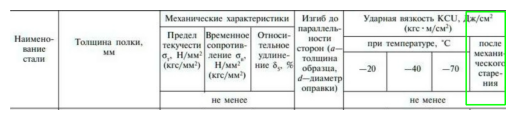

314 167 580 192


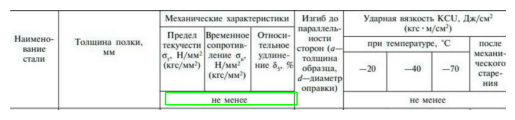

6 80 1001 165


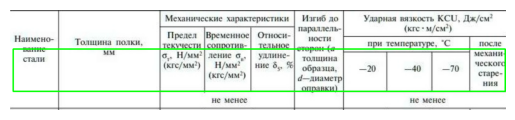

287 6 389 191


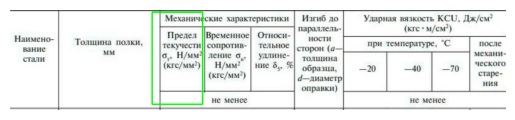

687 5 1001 42


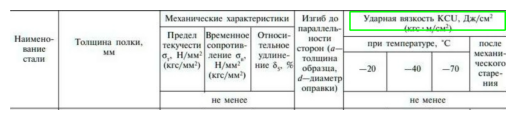

490 5 573 191


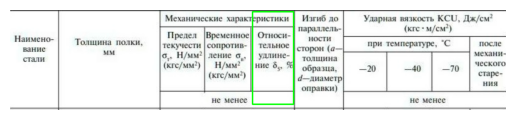

483 21 573 177


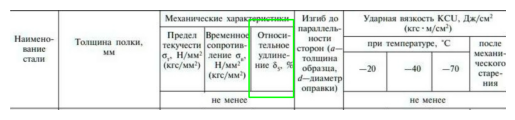

6 6 1000 192


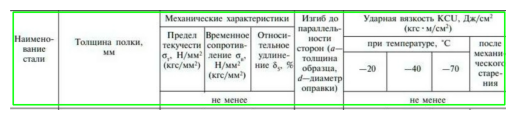

6 164 1000 192


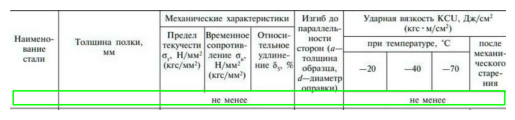

391 5 489 191


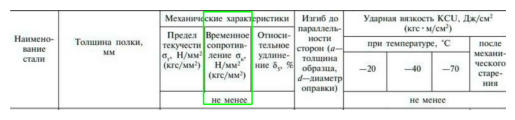

6 6 106 192


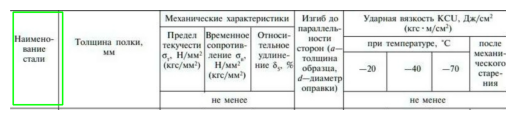

6 5 1000 42


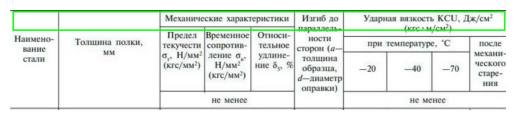

In [99]:
image = cv2.imread(os.path.join(input_folder, "000034.jpg"))

visualize_cells_local([image], [tables_cells])

### Research methods of parrallelic realisation

In [1]:
import time
import random

def process_image(image):
    n = random.randint(1, 5)
    time.sleep(n)
    return(image)

if __name__ == "__main__":
    images = [1, 2, 3, 4, 5]
    result = []

    start_time = time.time()
    for image in images:
        result.append(process_image(image))
    end_time = time.time()
    print("Time:", end_time - start_time, "seconds")
    print("Result", result)

Time: 18.002220153808594 seconds
Result [1, 2, 3, 4, 5]


In [16]:
import time
import random
from concurrent.futures import ThreadPoolExecutor

def process_image(image):
    n = random.randint(1, 5)
    time.sleep(n)
    # Здесь мы возвращаем пару (ключ, значение)
    return image, n

if __name__ == "__main__":
    images = [1, 2, 3, 4, 5]

    start_time = time.time()
    with ThreadPoolExecutor() as executor:
        results = dict(executor.map(process_image, images))
    end_time = time.time()
    print("Time:", end_time - start_time, "seconds")
    print("Results:", results)

Time: 5.004392623901367 seconds
Results: [1, 2, 3, 4, 5]


In [ ]:
import time
import random
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

def process_image(image):
    n = random.randint(1, 5)
    print(image, n)
    time.sleep(n)
    # Здесь мы возвращаем пару (ключ, значение)
    return image, n

if __name__ == "__main__":
    images = [1, 2, 3]  # Замените на ваш список изображений

    with ProcessPoolExecutor(max_workers=mp.cpu_count()) as executor:
        results = list(executor.map(process_image, images))

    for image, n in results:
        print(f"Image processed with random value: {n}")

In [12]:
import concurrent.futures
import random
import time

nums = [1,2,3,4,5,6,7,8,9,10]

def f(x):
    n = random.randint(1, 5)
    print(x, n)
    time.sleep(n)
    return x * x
def main():
    # Make sure the map and function are working
    print([val for val in map(f, nums)])

    # Test to make sure concurrent map is working
    with concurrent.futures.ProcessPoolExecutor() as executor:
        print([val for val in executor.map(f, nums)])

if __name__ == '__main__':
    main()

1 4
2 3
3 3
4 5
5 2
6 3
7 5
8 3
9 4
10 5
[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

### Poppler

In [ ]:
import os
import platform
import subprocess

def get_poppler_path():
    system = platform.system()
    
    if system == 'Windows':
        # На Windows, вы можете использовать "where" для поиска исполняемого файла
        result = subprocess.check_output("where pdfinfo", shell=True)
        pdfinfo_path = result.decode("utf-8").strip()
        poppler_path = os.path.dirname(pdfinfo_path)
        return poppler_path
    elif system == 'Linux':
        # На Linux, вы можете проверить путь к исполняемому файлу
        result = subprocess.check_output("which pdfinfo", shell=True)
        pdfinfo_path = result.decode("utf-8").strip()
        poppler_path = os.path.dirname(pdfinfo_path)
        return poppler_path
    else:
        # Другие операционные системы
        print("Unsupported OS")
        exit()

poppler_path = get_poppler_path()
print(poppler_path)

### Quantization of MASK-RCNN

In [10]:
import torch
import torchvision
from torch.quantization import quantize, prepare
import numpy as np
import torch.nn as nn

from PIL import Image
from maskrcnn import infer_utils
# from infer_utils import get_outputs
from torchvision.transforms import transforms as transforms
from maskrcnn.class_names import INSTANCE_CATEGORY_NAMES, CELLS_CATEGORY_NAMES

In [17]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(
    pretrained=False, num_classes=91
)
class_names = CELLS_CATEGORY_NAMES
# class_names = INSTANCE_CATEGORY_NAMES

model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(class_names), bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=len(class_names)*4, bias=True)
model.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256, len(class_names), kernel_size=(1, 1), stride=(1, 1))

# Set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
weights = os.path.join(os.getcwd(), "maskrcnn", "weights", "best_cell_detection.pth")
ckpt = torch.load(weights, map_location=device)
model.load_state_dict(ckpt['model'])
model.to(device).eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [18]:
quantized_model = torch.quantization.quantize_dynamic(model, dtype=torch.qint8)

In [19]:
torch.save(quantized_model.state_dict(), 'best_cell_detection_quantized_model.pth')